## 一、查看训练数据集

In [1]:
# 注册数据集
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog
from mpvit import add_mpvit_config  # register data here


# register_coco_instances("pest_train", {}, "datasets/coco/annotations/instances_train2017.json", "datasets/coco/train2017")
# register_coco_instances("pest_val", {}, "datasets/coco/annotations/instances_val2017.json", "datasets/coco/val2017")

# 获取数据集元数据
pest_metadata = MetadataCatalog.get('pest_train')  #  property: ['json_file', 'name', 'set', 'thing_classes', 'thing_dataset_id_to_contiguous_id']
pest_train_dataset = DatasetCatalog.get('pest_train')  # list of dict


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



In [2]:
# 查看元数据内容
pest_train_dataset[0]

{'file_name': 'datasets/coco_mix/train2017/02709.jpg',
 'height': 3648,
 'width': 5472,
 'image_id': 0,
 'annotations': [{'iscrowd': 0,
   'bbox': [3056, 1, 130, 66],
   'category_id': 3,
   'bbox_mode': <BoxMode.XYWH_ABS: 1>},
  {'iscrowd': 0,
   'bbox': [3466, 454, 104, 150],
   'category_id': 4,
   'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}

In [3]:
# 查看类别

class_names = pest_metadata.thing_classes

print(len(class_names))
print(class_names)

28
['6', '7', '8', '9', '10', '25', '41', '105', '110', '115', '148', '156', '222', '228', '235', '256', '280', '310', '387', '392', '394', '398', '401', '402', '430', '480', '485', '673']


In [5]:
pest_metadata.thing_dataset_id_to_contiguous_id

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27}

<ipython-input-17-1965e6cb1d74>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  histogram = np.zeros((num_classes,), dtype=np.int)
<ipython-input-17-1965e6cb1d74>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in

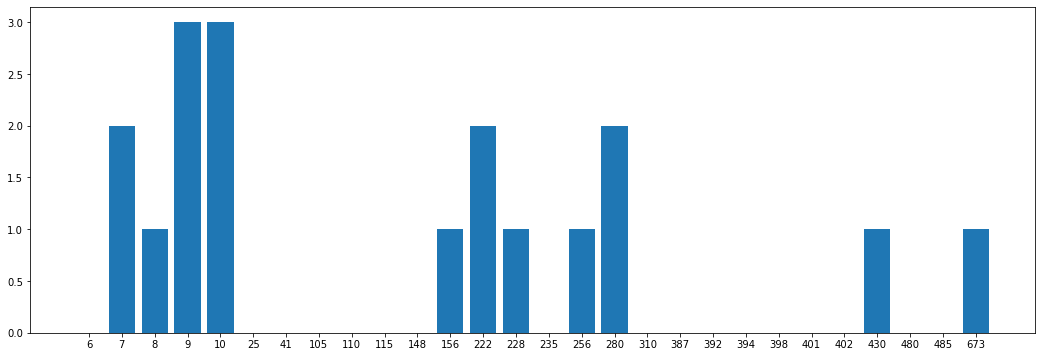

In [17]:
# 查看数据集各个类别分布

import itertools
import numpy as np
import matplotlib.pyplot as plt

def print_instances_class_histogram(dataset_dicts, class_names):
    """
    Args:
        dataset_dicts (list[dict]): list of dataset dicts.
        class_names (list[str]): list of class names (zero-indexed).
    """
    num_classes = len(class_names)
    hist_bins = np.arange(num_classes + 1)
    histogram = np.zeros((num_classes,), dtype=np.int)
    for entry in dataset_dicts:
        annos = entry["annotations"]
        classes = np.asarray(
            [x["category_id"] for x in annos if not x.get("iscrowd", 0)], dtype=np.int
        )
        if len(classes):
            assert classes.min() >= 0, f"Got an invalid category_id={classes.min()}"
            assert (
                classes.max() < num_classes
            ), f"Got an invalid category_id={classes.max()} for a dataset of {num_classes} classes"
        histogram += np.histogram(classes, bins=hist_bins)[0]
    
    # plot
    import matplotlib.pyplot as plt


    plt.figure(figsize=(18, 6))
    plt.bar(list(range(28)), histogram, tick_label=class_names)

    return histogram


histogram = print_instances_class_histogram(pest_train_dataset, class_names)

In [4]:
# 查看有标注的数据

idxs = []  # 所有有标注图片的index
i = 0
for id, meta_ in enumerate(pest_train_dataset):
    if meta_['annotations']:
        print(meta_['file_name'])
        idxs.append(id)
        i += 1

        if i > 10:
            break

datasets/coco/train2017/labelme6-17.jpg
datasets/coco/train2017/IP043000003.jpg
datasets/coco/train2017/labelme310-7.jpg
datasets/coco/train2017/IP041000173.jpg
datasets/coco/train2017/labelme480-2.jpg
datasets/coco/train2017/labelme394-8.jpg
datasets/coco/train2017/IP040000248.jpg
datasets/coco/train2017/labelme402-44.jpeg
datasets/coco/train2017/labelme280-33.jpg
datasets/coco/train2017/labelme41-16.jpg
datasets/coco/train2017/labelme392-50.jpg


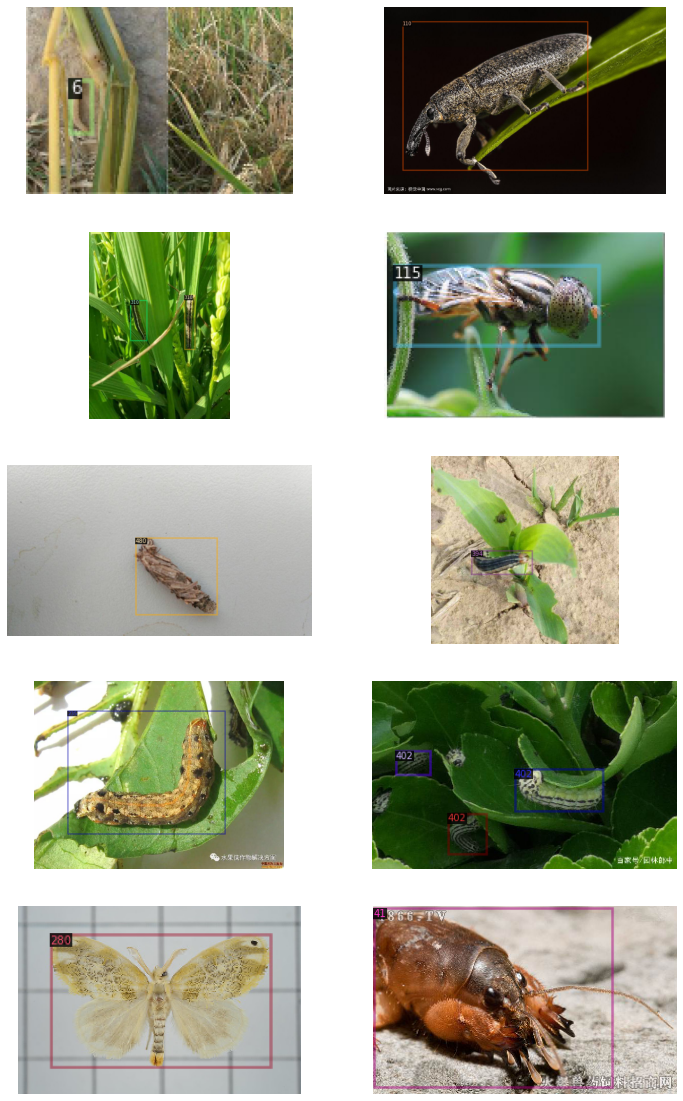

In [5]:
# 可视化检查

from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt


row, col = 5, 2

plt.figure(figsize=(12, 20))

for i in range(row):
    for j in range(col):
        idx = i * col + j
        plt.subplot(row, col, idx + 1)
        plt.axis('off')

        meta_ = pest_train_dataset[idxs[idx]]
        img = plt.imread(meta_['file_name'])

        v = Visualizer(img, metadata=pest_metadata, scale=0.5)
        out = v.draw_dataset_dict(meta_)
        plt.imshow(out.get_image())

## 二、使用预训练模型预测图片

(2448, 3264, 3)


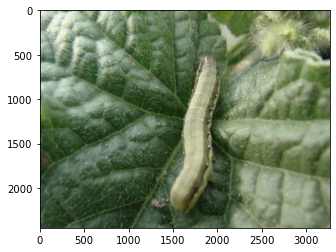

In [25]:
import matplotlib.pyplot as plt


# img_path = 'datasets/raw_data/images/02363.jpg'
# img_path = 'datasets/coco/train2017/03565.jpg'
# img_path = 'datasets/samples/03565.jpg'
img_path = '/opt/data/private/projects/TDCUP2022/datasets/coco/train2017/IP040000165.jpg'

img = plt.imread(img_path)
print(img.shape)
plt.imshow(img)

In [32]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from mpvit import add_mpvit_config


cfg = get_cfg()
# add_coat_config(cfg)
add_mpvit_config(cfg)
cfg.merge_from_file('configs/maskrcnn/mask_rcnn_mpvit_small_ms_3x.yaml')
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
cfg.MODEL.WEIGHTS = '/opt/data/private/projects/TDCUP2022/output/mask_rcnn_mpvit_small_ms_3x/model_0000429.pth'
cfg.freeze()


In [8]:
# from detectron2 import model_zoo


# cfg = get_cfg()
# # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

In [33]:
predictor = DefaultPredictor(cfg)
outputs = predictor(img)

In [34]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15,  9,  9,  9,  9,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9,  9], device='cuda:0')
Boxes(tensor([[   0.0000,  844.6711, 1715.7247, 2352.9324],
        [   0.0000, 1586.9667, 2846.7542, 2448.0000],
        [ 538.3663, 1036.8015, 2300.3157, 2448.0000],
        [1598.6567, 1203.2396, 3264.0000, 2366.0569],
        [1142.9060,   59.5887, 2452.9910, 2385.1677],
        [2123.9492,   61.8670, 3264.0000, 2384.2996],
        [ 382.5097,  809.6012, 3231.6001, 1974.3678],
        [1598.9163,   30.2152, 3264.0000, 1191.2761],
        [ 186.6652,   18.5422, 3036.5278,  799.4238],
        [   0.0000,  418.4885, 1780.2009, 1583.1017],
        [ 166.8021,   55.1332, 1469.6597, 2188.2517],
        [1516.3394,  448.9043, 3264.0000, 1961.4856],
        [ 753.8766,   47.7649, 2056.0591, 1991.9084],
        [1968.3352,   40.0482, 3132.6665, 1751.7344],
        [   0.0000, 1395.6459, 1839.3246, 2421.8296],
        [ 400.3486,  840.2924, 1967.28

In [11]:
# We can use `Visualizer` to draw the predictions on the image.

from detectron2.utils.visualizer import Visualizer


v = Visualizer(img, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

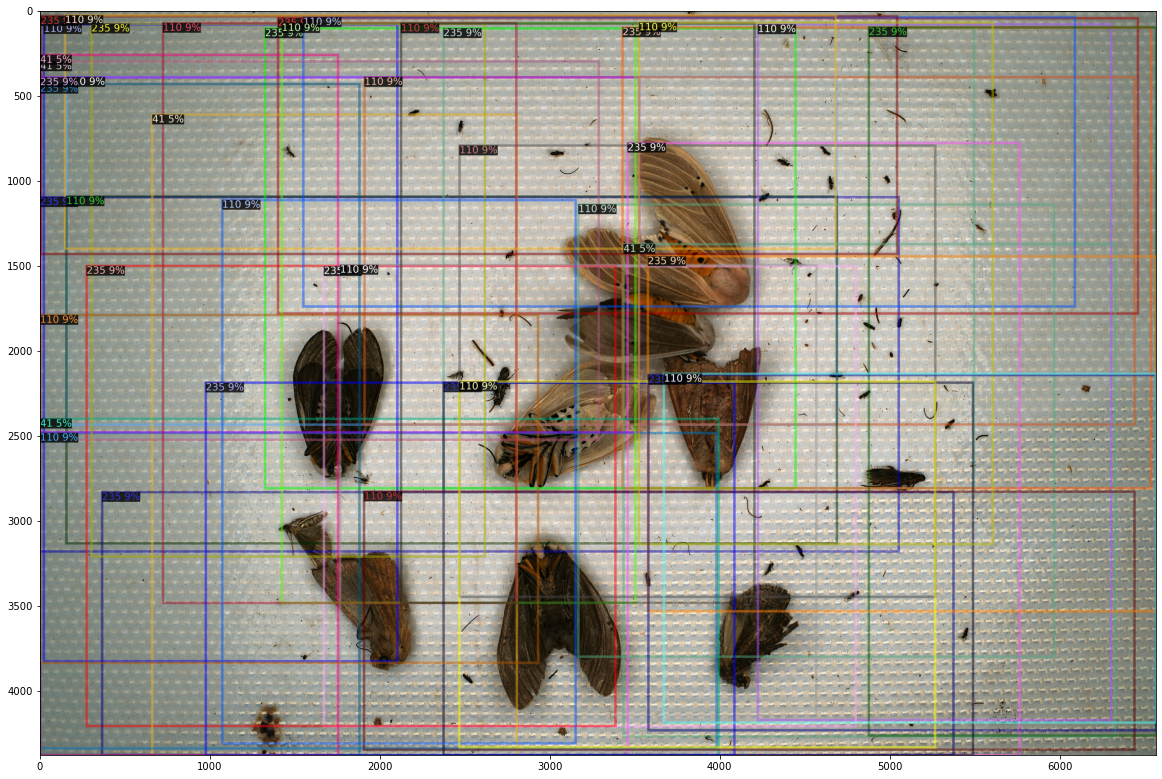

In [12]:
plt.figure(figsize=(20, 16))
plt.imshow(out.get_image())